In [1]:
import sys,os, pprint
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

<h1 align="center">Modeling a coupled excitatory-inhibitory (E-I) network with DiPDE/popnet</h1> 
<h3 align="center">August 24, 2017</h3> 

In this tutorial, we will demonstrate simulation of an E-I network consisting of homogenous excitatory (E) and inhibitory (I) populations using the DiPDE simulator. In this example, only the excitatory (E) population is being driven by excitatory input from the external (Ext) population. 

<img src="schematics_png/DiPDE_ei_net.png" alt = Drawing style = "width: 500px;"> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

# Building the network

We will build the network step-by-step as follows:

1) Create/parameterize the nodes (populations) in the internal network, namely the E and I populations

2) Create/parameterize the external population. 

3) Create/parameterize the edge (connection) from the external population to the E population.

4) Connect the E population to the I population

5) Run simulation and observe output

6) Exercise: Connect I to E and explore how the outputs change

In [2]:
#Create a folder called network. 
#Within this folder, we create a folder'recurrent_network' where the nodes and edges in our example will be saved
directory_name = 'network/recurrent_network/'

if not os.path.exists(directory_name):
    os.makedirs(directory_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> We will explore the directory structure for saving nodes and edges later. For now, just note that we will be creating node and edge parameter files and storing them in the 'network' folder </div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 1) Building E and I nodes </h2>

Let's start with creating a network object and add a single Excitatory population, followed by an Inhibitory population

<img src="schematics_png/ei_pop.png" alt = Drawing style = "width: 500px;"> 

In [3]:
#Import the NxNetwork module from modelingsdk. This module allows us to create a network object
#to which we can add nodes and edges respectively. 
from modelingsdk.builder.networks import NxNetwork

#Create network object
net = NxNetwork('V1')
#net.clear()

In [4]:
# Add 'E' node to 'net'
net.add_nodes(node_type_id='0', pop_name='excitatory', params_file='excitatory_pop.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> The default parameters for the excitatory population are stored in the json file. Let's see what they are. We will see below how the default parameters can be changed </div>

In [5]:
import pprint
import json

#Load the json file
with open('components/pop_models/excitatory_pop.json') as exc_data:
    exc_prs = json.load(exc_data)

#Print the parameters    
pprint.pprint(exc_prs)

{u'approx_order': None,
 u'dv': 0.0001,
 u'record': True,
 u'tau_m': 0.0429,
 u'update_method': u'gmres',
 u'v_max': 0.02,
 u'v_min': -0.05}


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> What do these parameters correspond to? </h2>

approx_order: None,      

dv: 0.0001,              #  grid-size for the membrane potential (in volts) 

record: True,            # 

tau_m: 0.0429,           #  membrane time-constant for each neuron in the population (in seconds)
 
update_method': u'gmres', # 
 
v_max: 0.02,             #  threshold membrane potential (in volts)
 
v_min: -0.05             #  resting membrane potential   (in volts)         

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> Exercise:
Follow the steps above to add an 'I' node (inhibitory population) to the network. You can set the node_type_id to 1 and replace 'excitatory' with 'inhibitory' for the other two fields.</div>  

In [6]:
# Add 'I' node to 'net'
net.add_nodes(node_type_id='1', pop_name='inhibitory', params_file='inhibitory_pop.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now that we have created the nodes and added them to the network, the next step is to save the nodes' information to a .csv file.

In [7]:
#Provide filename that will contain information about the types of nodes:
node_models_file = directory_name + 'node_types.csv' #filename to save to

#Save node information. The columns to be saved in this file are set by the user. Note that node_type_id is needed here
net.save_types(filename=node_models_file,
                   columns=['node_type_id', 'pop_name', 'params_file'])

In [8]:
# Let's display what is contained in the node_types file.
node_types_DF = pd.DataFrame.from_csv(node_models_file, sep = ' ')
node_types_DF

,pop_name,params_file
node_type_id,,
0,excitatory,excitatory_pop.json
1,inhibitory,inhibitory_pop.json


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 2) Building the Ext input node (as part of a separate 'Ext_input network')

Along the same lines as for the E-I network, we will now create an external input network with a single node. 

<img src="schematics_png/ei_ext_pop.png" alt = Drawing style = "width: 500px;"> 

In [9]:
#Create input network object
Ext_input = NxNetwork("Ext_input")
#Ext_input.clear()

#Add 'Ext' node to Ext_input 
Ext_input.add_nodes(node_type_id ='filter_001', ei='e', pop_name='input_filter', level_of_detail='filter')

#Create a separate directory for external inputs and provide filename to save to:
input_directory_name = 'network/source_input/'

if not os.path.exists(input_directory_name):
    os.makedirs(input_directory_name)

input_models_file = input_directory_name + 'input_node_types.csv'

#Save node information to file. 
Ext_input.save_types(filename=input_models_file, columns=['node_type_id','level_of_detail','ei', 'pop_name'])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> Exercise:
Display what is contained in the input_node_types file that you just saved </div>

In [10]:
input_node_types_DF = pd.DataFrame.from_csv(input_models_file, sep = ' ')
input_node_types_DF

,level_of_detail,ei,pop_name
node_type_id,,,
filter_001,filter,e,input_filter


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 3) Building the edge from Ext to E </h2>
Now we will create the edge connecting Ext population to E population

<img src="schematics_png/ei_ext_pop_conn1.png" alt = Drawing style = "width: 500px;"> 

In [11]:
Ext_input.connect(source = Ext_input.nodes(pop_name = 'input_filter'),
            target = net.nodes(pop_name = 'excitatory'),
            edge_params={'weight': 0.0025, 
                         'delay': 0.002, 
                         'nsyns': 10,
                         'params_file': 'InpToExc.json'} 
                         )

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> Let us unpack this a bit. To establish a connection, we provide the source (node named'ext_excitatory' in Ext_input) and the target (node named 'excitatory' in net). We also provide the parameters for the edge contained in edge_params. For DiPDE/popnet, each edge is specified by the following:

1) 'weight' : synaptic weight in volts

2) 'delay' : synaptic delay in seconds

3) 'nsyns' : number of synapses from source onto target. 

4) 'params_file': optional filename to save parameters to. </div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Build network... </h2>

In [12]:
Ext_input.build()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Save connection to csv file </h2>

In [13]:
#Specify filename to save to
input_edge_types_file   = input_directory_name + 'input_edge_types.csv'

#Save edge parameters
Ext_input.save_edge_types(filename=input_edge_types_file, opt_columns=['weight', 'delay', 'nsyns', 'params_file'])

input_edge_types_DF = pd.DataFrame.from_csv(input_edge_types_file, sep = ' ')
input_edge_types_DF

,target_query,source_query,weight,delay,nsyns,params_file
edge_type_id,,,,,,
0,pop_name=='excitatory',pop_name=='input_filter',0.0025,0.002,10,InpToExc.json


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 4) Build the edge from E to I and then build net </h2>
Now let's create the edge connecting E population to I population. Note now that both populations are nodes in net. Remember to save edge after specifying filename.  

<img src="schematics_png/ei_ext_pop_conn1and2.png" alt = Drawing style = "width: 500px;"> 

In [14]:
#connect E to I in net
net.connect(source = net.nodes(pop_name = 'excitatory'),
            target = net.nodes(pop_name = 'inhibitory'),
            edge_params={'weight': 0.005, 
                         'delay': 0.002, 
                         'nsyns': 20,
                         'params_file': 'ExcToInh.json'} 
                         )
#build net
net.build()

#Specify filename to save to
edge_types_file   = directory_name + 'edge_types.csv'

#Save edge parameters
net.save_edge_types(filename=edge_types_file, opt_columns=['weight', 'delay', 'nsyns', 'params_file'])

edge_types_DF = pd.DataFrame.from_csv(edge_types_file, sep = ' ')
edge_types_DF

,target_query,source_query,weight,delay,nsyns,params_file
edge_type_id,,,,,,
1,pop_name=='inhibitory',pop_name=='excitatory',0.005,0.002,20,ExcToInh.json


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 5) Run simulation </h2>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Config file </h2>
At this point, we have created and saved a bunch of files (nodes, edges etc.). All of this needs to be integrated together, which is what is done in a config file. A default config file ('config.json') has already been created for us that contains:

1) runtime settings for the simulation in 'run'. We will see below how to change the default settings.

2) filenames for the different nodes and edges (we used these names keeping the directory structure specified here)

3) filenames for where the output should be stored.

Feel free to also look at the config file directly as it will look better than the print function below.

In [15]:
#Import the utility config module from modelingsdk. This module integrates and puts together
#all the nodes and edges that we have saved while building our network

import modelingsdk.simulator.utils.config as config

configure = config.from_json('config.json')
pprint.pprint(configure)

{u'components': {u'models_dir': u'/home/rami/nb/friday_harbor/components/pop_models',
                 u'synapses_dir': u'/home/rami/nb/friday_harbor/components/synaptic_models'},
 u'external': {u'filter': {u'edge_types': u'/home/rami/nb/friday_harbor/network/source_input/input_edge_types.csv',
                           u'node_types': u'/home/rami/nb/friday_harbor/network/source_input/input_node_types.csv',
                           u'nodes': u'/home/rami/nb/friday_harbor/network/source_input/input_nodes.csv',
                           u'spike_trains': u'/home/rami/nb/friday_harbor/network/source_input/poisson_input_spk_train.nwb',
                           u'trial': u'trial_1'}},
 u'internal': {u'edge_types': u'/home/rami/nb/friday_harbor/network/recurrent_network/edge_types.csv',
               u'edges': u'/home/rami/nb/friday_harbor/network/recurrent_network/edges.h5',
               u'node_types': u'/home/rami/nb/friday_harbor/network/recurrent_network/node_types.csv'},
 u'mani

In [16]:
#Import the Graph module from modelingsdk. This module creates a full-fledged graph, in
#accordance with the rules of the underlying DiPDE/popnet simulator, using
#all the nodes and edges that we have instantiated as part of our network. 

from modelingsdk.simulator.popnet.graph import Graph

#Create a graph structure using the nodes and edges specified in the config file.
graph = Graph(configure)

graph.get_population('input_filter',network='filter').firing_rate = 10.0

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Run the simulation </h2>

In [17]:
#Import the Network module from the popnet simulator in modelingsdk. This module creates a
#network that is in accordance with the underlying DiPDE simulator. 

from modelingsdk.simulator.popnet.network import Network

full_net = Network(configure,graph)
full_net.build()
full_net.run()

#print ff_net.connections

External Population input_filter firing at a rate of 10.0 Hz.
running simulation...
done simulation.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Analyze firing rate outputs of the E and I populations </h2>

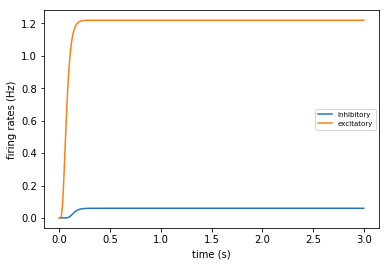

In [18]:
from modelingsdk.analyzer.visualization.spikes import plot_rates_popnet

cells_file = configure['internal']['node_types']
rates_file = configure['output']['rates_file']
plot_rates_popnet(cells_file,rates_file,model_keys='pop_name')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Changing default parameters in the config </h2>

<p> Let's see some simple examples of changing default parameters in the config file
Change duration of simulation from 3 seconds to 0.5 seconds </div>

In [19]:
configure['run']['duration'] = 0.5

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> Change firing rate and membrane time constant of input excitatory population (Ext) after checking the default value </div> 

In [20]:
input_pop = graph.get_population('input_filter',network='filter')
print input_pop.firing_rate
input_pop.firing_rate = 25.0  #(Firing rate in Hz)
print input_pop.firing_rate

exc_pop = graph.get_population('excitatory')
print exc_pop.tau_m
exc_pop.tau_m = 0.02
print exc_pop.tau_m

10.0
25.0
0.0429
0.02


In [21]:
#Build network and run simulation using new config parameters 

full_net_2 = Network(configure,graph)
full_net_2.build()
full_net_2.run()

External Population input_filter firing at a rate of 25.0 Hz.
running simulation...
done simulation.


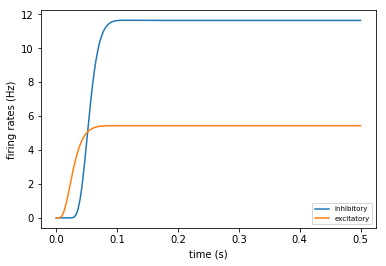

In [22]:
#Analyze outputs for new config

cells_file = configure['internal']['node_types']
rates_file = configure['output']['rates_file']
plot_rates_popnet(cells_file,rates_file,model_keys='pop_name')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h2> Exercise (time permitting): Add an I to E connection, save the edge, build the network and re-run the simulation to see how the outputs change </h2>

In [23]:
#connect I to E in net
net.connect(source = net.nodes(pop_name = 'inhibitory'),
            target = net.nodes(pop_name = 'excitatory'),
            edge_params={'weight': -0.001, 
                         'delay': 0.002, 
                         'nsyns': 10,
                         'params_file': 'InhToExc.json'} 
                         )
#build net
net.build()

#Specify filename to save to
edge_types_file   = directory_name + 'edge_types.csv'

#Save edge parameters
net.save_edge_types(filename=edge_types_file, opt_columns=['weight', 'delay', 'nsyns', 'params_file'])

edge_types_DF = pd.DataFrame.from_csv(edge_types_file, sep = ' ')
edge_types_DF

,target_query,source_query,weight,delay,nsyns,params_file
edge_type_id,,,,,,
1,pop_name=='inhibitory',pop_name=='excitatory',0.005,0.002,20,ExcToInh.json
2,pop_name=='excitatory',pop_name=='inhibitory',-0.001,0.002,10,InhToExc.json


External Population input_filter firing at a rate of 25.0 Hz.
running simulation...
done simulation.


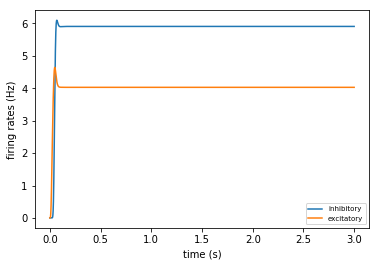

In [24]:
configure = config.from_json('config.json')
graph = Graph(configure)

#input_pop = graph.get_population('input_filter',network='filter')
graph.get_population('input_filter',network='filter').firing_rate = 25.0
graph.get_population('excitatory').tau_m = 0.02
#input_pop.firing_rate

ei_net = Network(configure,graph)
ei_net.build()
ei_net.run()

rates_file = configure['output']['rates_file']
plot_rates_popnet(cells_file,rates_file,model_keys='pop_name')